In [8]:
# STEP 1: Imports & Dataset Loading
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.models as models
from PIL import Image

# PyTorch imports
import torch
from torchvision import transforms, datasets

In [9]:
!py -m pip install pandas

In [10]:
# Path to your dataset root folder (each subfolder = class)
dataset_path = r"garbage-dataset"  # <-- change this

Downloads/GreenScan/AiModel/garbage-dataset

In [11]:
os.getcwd()

'C:\\Users\\talha\\Downloads\\GreenScan\\AiModel'

Found 10 categories: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
✅ Loaded 100 images for class 'battery'
✅ Loaded 102 images for class 'biological'
✅ Loaded 100 images for class 'cardboard'
✅ Loaded 100 images for class 'clothes'
✅ Loaded 100 images for class 'glass'
✅ Loaded 101 images for class 'metal'
✅ Loaded 100 images for class 'paper'
✅ Loaded 75 images for class 'plastic'
✅ Loaded 100 images for class 'shoes'
✅ Loaded 95 images for class 'trash'


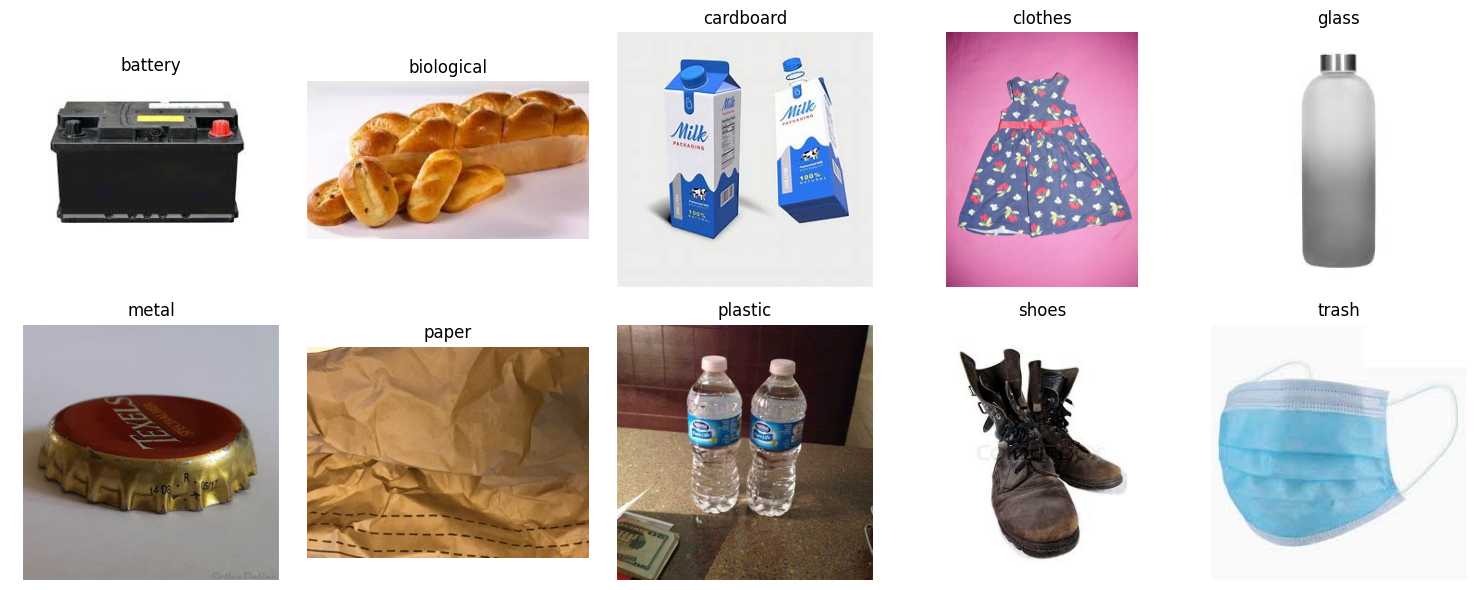

In [12]:
# Check folders
# Build a dictionary of DataFrames (one per category)
categories = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
print(f"Found {len(categories)} categories:", categories)

category_dfs = {}

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    data = []
    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        try:
            img = Image.open(img_path).convert("RGB")
            data.append({"path": img_path, "image": img})
        except Exception as e:
            print(f"❌ Error loading {img_file}: {e}")
    
    df = pd.DataFrame(data)
    category_dfs[category] = df
    print(f"✅ Loaded {len(df)} images for class '{category}'")

# Show one random image per category
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for ax, category in zip(axes, categories):
    img = random.choice(category_dfs[category]["image"])
    ax.imshow(img)
    ax.set_title(category)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [15]:
import os
import pandas as pd
from PIL import Image

base_dir = "./garbage-dataset"

categories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
print(f"Found {len(categories)} categories: {categories}")

dataframes = {}

for category in categories:
    folder = os.path.join(base_dir, category)
    image_paths = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    df = pd.DataFrame({'image_path': image_paths})
    dataframes[category] = df


Found 10 categories: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [16]:
# ========================================
# 🧩 Step 2: Image Preprocessing + Embedding Extraction
# ========================================

# --- Define Preprocessing Transform ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # standard input size for ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# --- Load Pretrained Model (ResNet50) ---
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # remove final classification layer
resnet.eval()

# --- Move model to GPU if available ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

# --- Helper Function to Extract Embedding ---
def get_embedding(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            embedding = resnet(image).squeeze().cpu().numpy()
        return embedding
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return np.zeros(2048)  # ResNet50 outputs 2048-dim vector

# --- Generate Embeddings for Each Category ---
embedding_tables = {}

for category, df in dataframes.items():
    print(f"🔍 Extracting embeddings for category: {category} ({len(df)} images)")
    df['embedding'] = df['image_path'].apply(get_embedding)
    embedding_tables[category] = df

print("✅ Embeddings extracted successfully!")

# --- Optional: Save intermediate embedding data ---
for cat, df in embedding_tables.items():
    df.to_pickle(f'embeddings_{cat}.pkl')


🔍 Extracting embeddings for category: battery (100 images)
🔍 Extracting embeddings for category: biological (102 images)
🔍 Extracting embeddings for category: cardboard (100 images)
🔍 Extracting embeddings for category: clothes (100 images)
🔍 Extracting embeddings for category: glass (100 images)
🔍 Extracting embeddings for category: metal (101 images)
🔍 Extracting embeddings for category: paper (100 images)
🔍 Extracting embeddings for category: plastic (75 images)
🔍 Extracting embeddings for category: shoes (100 images)
🔍 Extracting embeddings for category: trash (95 images)
✅ Embeddings extracted successfully!


In [30]:
# add label coloum to embeddings
import pandas as pd, glob, os
import numpy as np

# --- Load all embedding tables ---
pkl_files = glob.glob("embeddings/*.pkl")
all_embeddings = []

for file in pkl_files:
    category = os.path.basename(file).replace("embeddings_", "").replace(".pkl", "")
    df = pd.read_pickle(file)
    df['label'] = category  # Assign category label
    all_embeddings.append(df)

# Combine all embeddings into one DataFrame
all_embeddings_df = pd.concat(all_embeddings, ignore_index=True)

# --- Convert embeddings to matrix ---
embedding_matrix = np.vstack(all_embeddings_df['embedding'].values)
embedding_df = pd.DataFrame(embedding_matrix, columns=[f'f_{i}' for i in range(embedding_matrix.shape[1])])

# Add labels
embedding_df['label'] = all_embeddings_df['label']

# --- Save to CSV ---
embedding_df.to_csv("embeddings.csv", index=False)
print("✅ Saved embeddings.csv with shape:", embedding_df.shape)
print("Categories:", embedding_df['label'].unique())


✅ Saved embeddings.csv with shape: (973, 2049)
Categories: ['battery' 'biological' 'cardboard' 'clothes' 'glass' 'metal' 'paper'
 'plastic' 'shoes' 'trash']


In [31]:
import pandas as pd, glob

pkl_files = glob.glob("embeddings/*.pkl")
print("Found:", len(pkl_files), "files")

# Look at the first one
df = pd.read_pickle(pkl_files[0])
print("Columns:", df.columns.tolist())
print(df.head())


Found: 10 files
Columns: ['image_path', 'embedding']
                                  image_path  \
0  ./garbage-dataset\battery\battery_671.jpg   
1  ./garbage-dataset\battery\battery_672.jpg   
2  ./garbage-dataset\battery\battery_673.jpg   
3  ./garbage-dataset\battery\battery_674.jpg   
4  ./garbage-dataset\battery\battery_675.jpg   

                                           embedding  
0  [0.61551166, 1.7868506, 0.06038273, 0.04787401...  
1  [0.4445175, 0.6290143, 0.03282716, 0.7932699, ...  
2  [0.54135066, 0.22920302, 0.26889226, 0.0193302...  
3  [1.4275314, 0.40981522, 0.9348895, 0.46889263,...  
4  [0.23282005, 0.33821046, 0.022324976, 0.279237...  


In [35]:
# ========================================
# 🧩 Step 3: Combine All Embeddings into One Table
# ========================================
import pandas as pd
import numpy as np
import os
import glob

# --- Load all embedding pickle files ---
pkl_files = glob.glob("embeddings/*.pkl")
all_embeddings = []

for file in pkl_files:
    # Extract the category name from filename, e.g. "embeddings_battery.pkl" -> "battery"
    category = os.path.basename(file).replace("embeddings_", "").replace(".pkl", "")
    
    # Load the DataFrame
    df = pd.read_pickle(file)
    
    # Add label column
    df['label'] = category
    
    # Store it
    all_embeddings.append(df)

# --- Combine all categories into one DataFrame ---
all_embeddings_df = pd.concat(all_embeddings, ignore_index=True)

# --- Build numeric embedding matrix ---
embedding_matrix = np.vstack(all_embeddings_df['embedding'].values)
embedding_df = pd.DataFrame(embedding_matrix, columns=[f'f_{i}' for i in range(embedding_matrix.shape[1])])

# --- Attach labels ---
embedding_df['label'] = all_embeddings_df['label']

# --- Save final CSV ---
embedding_df.to_csv("embeddings.csv", index=False)

print("✅ Saved embeddings.csv with shape:", embedding_df.shape)
print("Categories found:", embedding_df['label'].unique())
print(embedding_df.head())


✅ Saved embeddings.csv with shape: (973, 2049)
Categories found: ['battery' 'biological' 'cardboard' 'clothes' 'glass' 'metal' 'paper'
 'plastic' 'shoes' 'trash']
        f_0       f_1       f_2       f_3       f_4       f_5       f_6  \
0  0.615512  1.786851  0.060383  0.047874  0.166736  0.198142  0.661664   
1  0.444517  0.629014  0.032827  0.793270  0.299374  0.248418  0.510433   
2  0.541351  0.229203  0.268892  0.019330  0.072979  0.119476  0.068707   
3  1.427531  0.409815  0.934889  0.468893  0.345901  1.204622  0.371151   
4  0.232820  0.338210  0.022325  0.279237  0.812622  0.293516  0.050013   

        f_7       f_8       f_9  ...    f_2039    f_2040    f_2041    f_2042  \
0  0.020075  0.438152  0.212201  ...  0.018846  0.080244  0.145652  0.054401   
1  0.728977  0.000262  0.233652  ...  1.302276  0.100881  0.368441  0.072884   
2  0.361023  0.274176  0.329507  ...  0.272708  0.024589  0.140653  0.058983   
3  0.880025  0.079409  0.397895  ...  0.440456  0.081382  0.312724

✅ Clustering Metrics:
Adjusted Rand Index (ARI): 0.5829
Normalized Mutual Info (NMI): 0.6992
Homogeneity: 0.6921, Completeness: 0.7063, V-measure: 0.6992
Approximate Accuracy: 0.7410


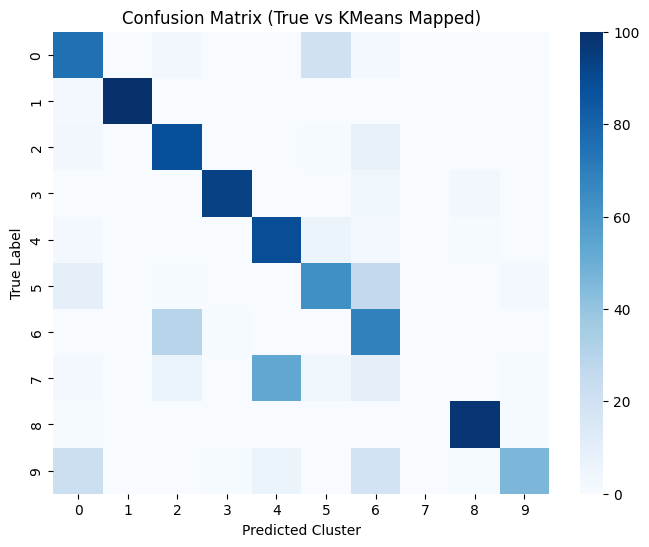

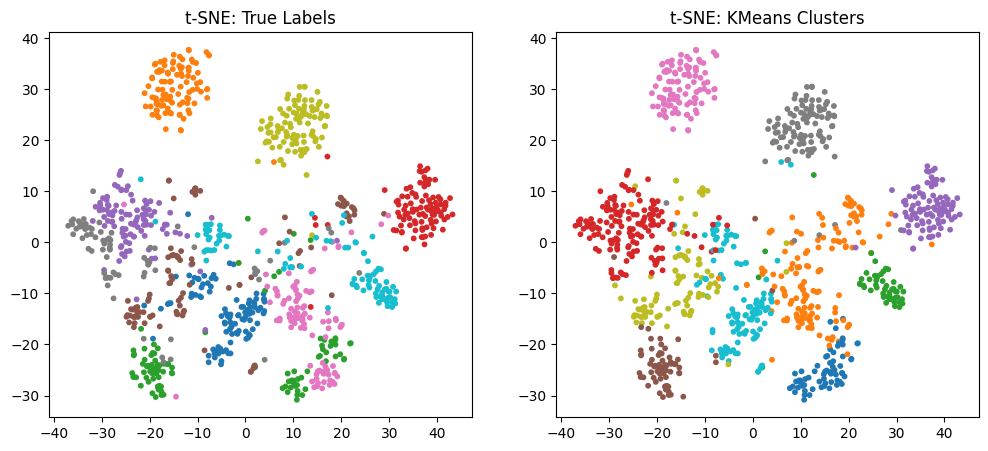

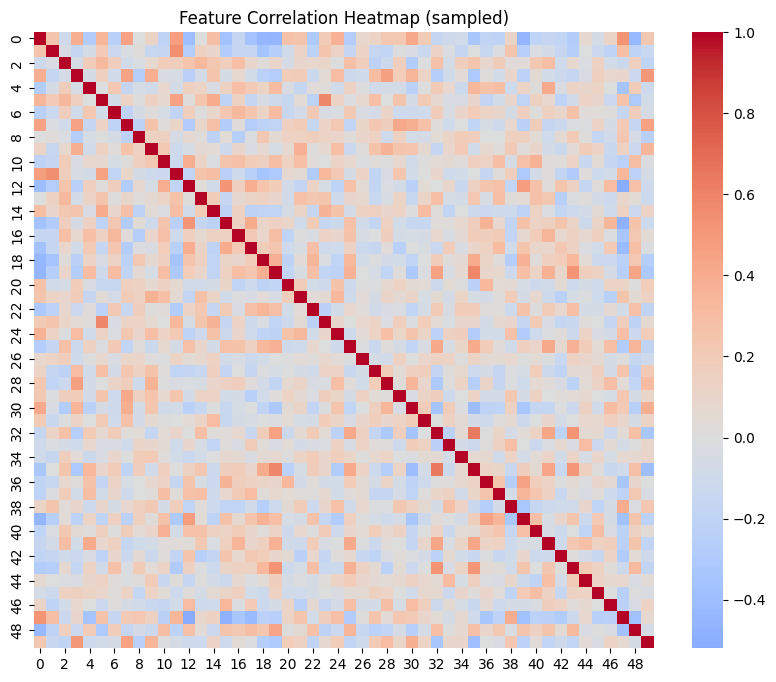

In [42]:
# --- Step 4: K-Means Clustering & Validation ---

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_completeness_v_measure,
    confusion_matrix,
    accuracy_score
)
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load embeddings ---
df = pd.read_csv("embeddings.csv")

# --- Prepare data and labels ---
X = df.drop(columns=["label"]).values
y_true = LabelEncoder().fit_transform(df["label"])

# --- KMeans clustering ---
kmeans = KMeans(n_clusters=10, random_state=42, n_init=20)
y_pred = kmeans.fit_predict(X)

# --- Metrics ---
ari = adjusted_rand_score(y_true, y_pred)
nmi = normalized_mutual_info_score(y_true, y_pred)
h, c, v = homogeneity_completeness_v_measure(y_true, y_pred)

# --- Align cluster labels to true labels for crude accuracy ---
# (optional heuristic: find best label for each cluster)
from scipy.stats import mode
labels_map = {}
for i in range(10):
    mask = (y_pred == i)
    if np.any(mask):
        labels_map[i] = mode(y_true[mask], keepdims=True)[0][0]
    else:
        labels_map[i] = -1

mapped_preds = np.array([labels_map[c] for c in y_pred])
acc = accuracy_score(y_true, mapped_preds)

print(f"✅ Clustering Metrics:")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Info (NMI): {nmi:.4f}")
print(f"Homogeneity: {h:.4f}, Completeness: {c:.4f}, V-measure: {v:.4f}")
print(f"Approximate Accuracy: {acc:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, mapped_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix (True vs KMeans Mapped)")
plt.xlabel("Predicted Cluster")
plt.ylabel("True Label")
plt.show()

# --- t-SNE Visualization ---
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X[:1000])  # limit to avoid slowdown

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_true[:1000], cmap="tab10", s=10)
plt.title("t-SNE: True Labels")

plt.subplot(1,2,2)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_pred[:1000], cmap="tab10", s=10)
plt.title("t-SNE: KMeans Clusters")

plt.show()

# --- Feature Correlation Heatmap (optional) ---
corr = np.corrcoef(X[:200, :50].T)  # subset for speed
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap (sampled)")
plt.show()


C:\Users\talha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


✅ Per-class metrics saved to 'kmeans_per_class_metrics.csv'


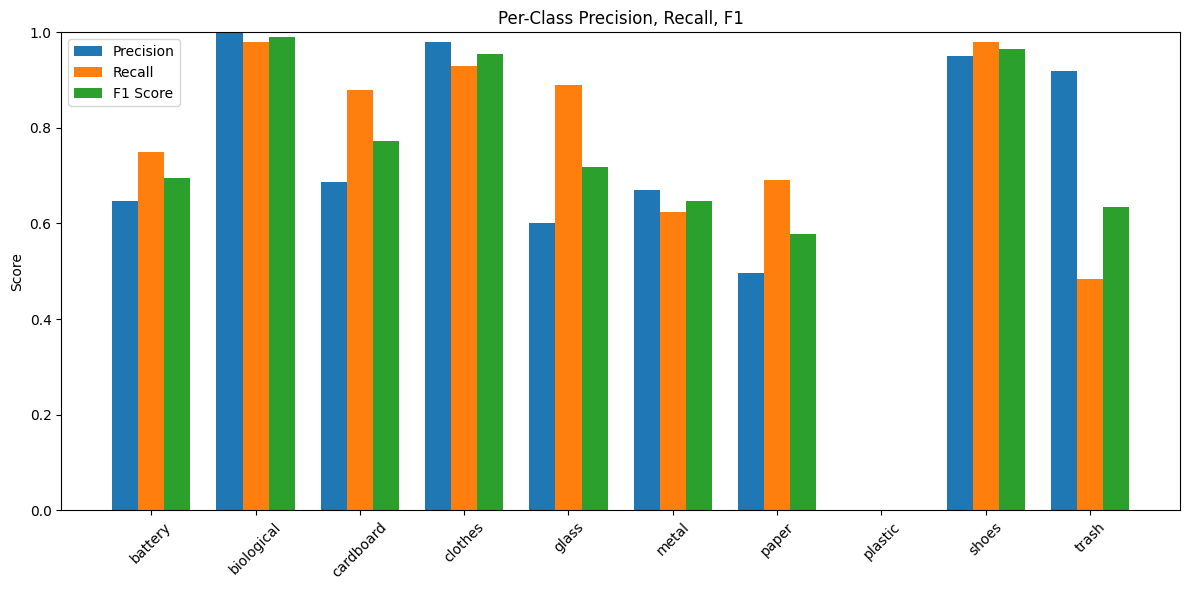

⚠️ Class plastic had no predicted samples
⚠️ Classes with low precision (likely overlaps in clusters):
  class_name  precision    recall  f1_score
0    battery   0.646552  0.750000  0.694444
2  cardboard   0.687500  0.880000  0.771930
4      glass   0.601351  0.890000  0.717742
5      metal   0.670213  0.623762  0.646154
6      paper   0.496403  0.690000  0.577406
7    plastic   0.000000  0.000000  0.000000

⚠️ Classes with low recall (clusters capturing multiple classes):
  class_name  precision    recall  f1_score
5      metal   0.670213  0.623762  0.646154
6      paper   0.496403  0.690000  0.577406
7    plastic   0.000000  0.000000  0.000000
9      trash   0.920000  0.484211  0.634483
✅ Metrics plot saved to 'plots/per_class_metrics.png'


In [44]:
# Step 6: Validation & Insights

from sklearn.metrics import precision_recall_fscore_support
import os

# --- Compute per-class precision, recall, F1 ---
precision, recall, f1, support = precision_recall_fscore_support(y_true, mapped_preds, labels=np.unique(y_true))

# Create DataFrame for easy saving & plotting
metrics_df = pd.DataFrame({
    "class_id": np.unique(y_true),
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "support": support
})

# Optional: map class ids back to original labels
label_encoder = LabelEncoder()
label_encoder.fit(df["label"])
metrics_df["class_name"] = label_encoder.inverse_transform(metrics_df["class_id"])

# Save metrics to CSV
metrics_df.to_csv("kmeans_per_class_metrics.csv", index=False)
print("✅ Per-class metrics saved to 'kmeans_per_class_metrics.csv'")
metrics_df

plt.figure(figsize=(12,6))
x = np.arange(len(metrics_df))
width = 0.25

plt.bar(x - width, metrics_df["precision"], width, label="Precision")
plt.bar(x, metrics_df["recall"], width, label="Recall")
plt.bar(x + width, metrics_df["f1_score"], width, label="F1 Score")

plt.xticks(x, metrics_df["class_name"], rotation=45)
plt.ylabel("Score")
plt.title("Per-Class Precision, Recall, F1")
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.show()

# Thresholds for overlap (adjust as needed)
low_precision_classes = metrics_df[metrics_df["precision"] < 0.7]
low_recall_classes = metrics_df[metrics_df["recall"] < 0.7]

for i, p in enumerate(precision):
    if p == 0:
        print(f"⚠️ Class {label_encoder.inverse_transform([i])[0]} had no predicted samples")

print("⚠️ Classes with low precision (likely overlaps in clusters):")
print(low_precision_classes[["class_name","precision","recall","f1_score"]])

print("\n⚠️ Classes with low recall (clusters capturing multiple classes):")
print(low_recall_classes[["class_name","precision","recall","f1_score"]])

if not os.path.exists("plots"):
    os.makedirs("plots")

plt.figure(figsize=(12,6))
plt.bar(x - width, metrics_df["precision"], width, label="Precision")
plt.bar(x, metrics_df["recall"], width, label="Recall")
plt.bar(x + width, metrics_df["f1_score"], width, label="F1 Score")
plt.xticks(x, metrics_df["class_name"], rotation=45)
plt.ylabel("Score")
plt.title("Per-Class Precision, Recall, F1")
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.savefig("plots/per_class_metrics.png")
plt.close()
print("✅ Metrics plot saved to 'plots/per_class_metrics.png'")


📊 Plastic images distribution across predicted clusters/classes:
pred_class
glass        53
paper         9
cardboard     6
metal         4
battery       2
trash         1
Name: count, dtype: int64


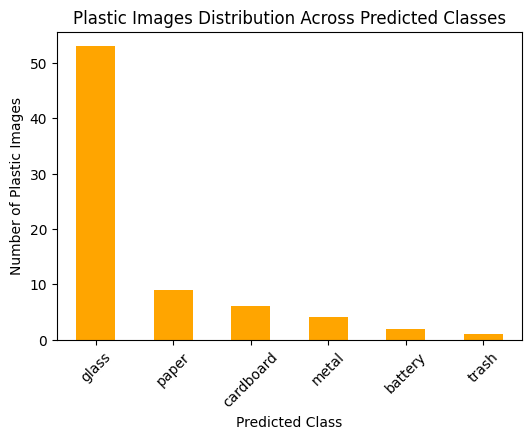

In [45]:
# First, map cluster IDs to original class names using your labels_map
cluster_to_class = {i: label_encoder.inverse_transform([labels_map[i]])[0] if labels_map[i] != -1 else "None"
                    for i in range(10)}

# Add cluster predictions and mapped class names to the DataFrame
df['pred_cluster'] = y_pred
df['pred_class'] = df['pred_cluster'].map(cluster_to_class)

# Filter only Plastic images
plastic_df = df[df['label'] == 'plastic']

# Count which predicted classes Plastic images ended up in
plastic_overlap = plastic_df['pred_class'].value_counts()

print("📊 Plastic images distribution across predicted clusters/classes:")
print(plastic_overlap)
plt.figure(figsize=(6,4))
plastic_overlap.plot(kind='bar', color='orange')
plt.title("Plastic Images Distribution Across Predicted Classes")
plt.ylabel("Number of Plastic Images")
plt.xlabel("Predicted Class")
plt.xticks(rotation=45)
plt.show()
